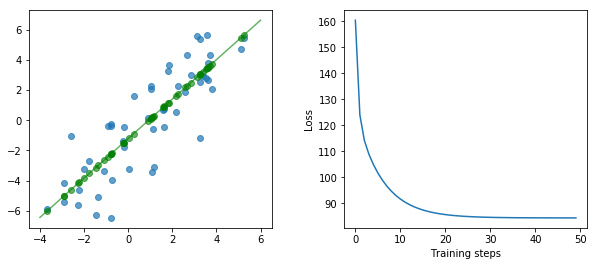

In [1]:
#@test {"output": "ignore"}
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set up the data with a noisy linear relationship between X and Y.
num_examples = 50
X = np.array([np.linspace(-2, 4, num_examples), np.linspace(-6, 6, num_examples)])
X += np.random.randn(2, num_examples)
x, y = X
bias_with_x = np.array([(1., a) for a in x]).astype(np.float32)

losses = []
training_steps = 50
learning_rate = 0.002

with tf.Session() as sess:
    # Set up all the tensors, variables, and operations.
    input = tf.constant(bias_with_x)
    target = tf.constant(np.transpose([y]).astype(np.float32))
    weights = tf.Variable(tf.random_normal([2, 1], 0, 0.1))

    tf.global_variables_initializer().run()

    yhat = tf.matmul(input, weights)
    yerror = tf.subtract(yhat, target)
    loss = tf.nn.l2_loss(yerror)
  
    update_weights = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
    for _ in range(training_steps):
        # Repeatedly run the operations, updating the TensorFlow variable.
        update_weights.run()
        losses.append(loss.eval())

    # Training is done, get the final values for the graphs
    betas = weights.eval()
    yhat = yhat.eval()

# Show the fit and the loss over time.
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)
ax1.scatter(x, y, alpha=.7)
ax1.scatter(x, np.transpose(yhat)[0], c="g", alpha=.6)
line_x_range = (-4, 6)
ax1.plot(line_x_range, [betas[0] + a * betas[1] for a in line_x_range], "g", alpha=0.6)
ax2.plot(range(0, training_steps), losses)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training steps")
plt.show()

### Load Glove word embeddings.

In [2]:
from pathlib import Path

import numpy as np

if __name__ == '__main__':
  # Load vocab.
  with Path('data/vocab.words.txt').open() as f:
    word_to_idx = {line.strip(): idx for idx, line in enumerate(f)}
  size_vocab = len(word_to_idx)

  # Array of zeros
  embeddings = np.zeros((size_vocab, 300))

  # Get relevant glove vectors
  found = 0
  print('Reading GloVe file (may take a while)')
  with open('data/glove.840B.300d.txt', encoding="utf-8") as f:
    for line_idx, line in enumerate(f):
      if line_idx % 100000 == 0:
        print('- At line {}'.format(line_idx))
      line = line.strip().split()
      if len(line) != 300 + 1:
        continue
      word = line[0]
      embedding = line[1:]
      if word in word_to_idx:
        found += 1
        word_idx = word_to_idx[word]
        embeddings[word_idx] = embedding
  print('- done. Found {} vectors for {} words'.format(found, size_vocab))

  # Save np.array to file
  np.savez_compressed('data/glove.npz', embeddings=embeddings)

Reading GloVe file (may take a while)
- At line 0
- At line 100000
- At line 200000
- At line 300000
- At line 400000
- At line 500000
- At line 600000
- At line 700000
- At line 800000
- At line 900000
- At line 1000000
- At line 1100000
- At line 1200000
- At line 1300000
- At line 1400000
- At line 1500000
- At line 1600000
- At line 1700000
- At line 1800000
- At line 1900000
- At line 2000000
- At line 2100000
- done. Found 22 vectors for 22 words


### Generate dataset.

In [2]:
import tensorflow as tf
import functools
from pathlib import Path
import json

DATADIR = 'data'

# Params
params = {
  'dim_chars': 100,
  'dim': 300,
  'dropout': 0.5,
  'num_oov_buckets': 1,
  'epochs': 25,
  'batch_size': 20,
  'buffer': 15000,
  'filters': 50,
  'kernel_size': 3,
  'lstm_size': 100,                                             
  'words': str(Path(DATADIR, 'vocab.words.txt')),
  'chars': str(Path(DATADIR, 'vocab.chars.txt')),
  'tags':  str(Path(DATADIR, 'vocab.tags.txt')),
  'glove': str(Path(DATADIR, 'glove.npz'))
}                       
                                    
with Path(DATADIR, 'params.json').open('w') as f:
  json.dump(params, f, indent=4, sort_keys=True)

def parse_fn(line_words, line_tags):
    # Encode in Bytes for TF
    words = [w.encode() for w in line_words.strip().split()]
    tags = [t.encode() for t in line_tags.strip().split()]
    assert len(words) == len(tags), "Words and tags lengths don't match"
    
    # Chars
    chars = [[c.encode() for c in w] for w in line_words.strip().split()]
    lengths = [len(c) for c in chars]
    max_len = max(lengths)
    chars = [c + [b'<pad>'] * (max_len - l) for c, l in zip(chars, lengths)]
    
    return ((words, len(words)), (chars, lengths)), tags

def generator_fn(words, tags):
  with Path(words).open('r') as f_words, Path(tags).open('r') as f_tags:
    for line_words, line_tags in zip(f_words, f_tags):
      yield parse_fn(line_words, line_tags)

def input_fn(words, tags, params=None, shuffle_and_repeat=False):
    params = params if params is not None else {}
    shapes = (
      (([None], ()),           # (words, nwords)
      ([None, None], [None])), # (chars, nchars)  
      [None]        # tags
    )                   
    
    types = (
      ((tf.string, tf.int32),
      (tf.string, tf.int32)),  
      tf.string
    )
    
    defaults = (
      (('<pad>', 0),
      ('<pad>', 0)), 
      'O'
    )
              
    dataset = tf.data.Dataset.from_generator(
      functools.partial(generator_fn, words, tags),
      output_types=types, output_shapes=shapes
    )
              
    if shuffle_and_repeat:
      dataset = dataset.shuffle(params['buffer']).repeat(params['epochs'])
    
    return (
      dataset
      .padded_batch(params.get('batch_size', 20), shapes, defaults)
      .prefetch(1)
    )

def fwords(name):
  return str(Path(DATADIR, '{}.words.txt'.format(name)))

def ftags(name):
  return str(Path(DATADIR, '{}.tags.txt'.format(name)))

# Estimator, train and evaluate
train_inpf = functools.partial(input_fn, fwords('train'), ftags('train'), params, shuffle_and_repeat=True)
eval_inpf = functools.partial(input_fn, fwords('testa'), ftags('testa'))

print('Done')

Done


### Metrics

In [4]:
from tensorflow.python.ops.metrics_impl import _streaming_confusion_matrix

def safe_div(numerator, denominator):
    numerator, denominator = tf.to_float(numerator), tf.to_float(denominator)
    zeros = tf.zeros_like(numerator, dtype=numerator.dtype)
    denominator_is_zero = tf.equal(denominator, zeros)
    return tf.where(denominator_is_zero, zeros, numerator / denominator)

def pr_re_fbeta(cm, pos_indices, beta=1):
    num_classes = cm.shape[0]
    neg_indices = [i for i in range(num_classes) if i not in pos_indices]
    cm_mask = np.ones([num_classes, num_classes])
    cm_mask[neg_indices, neg_indices] = 0
    diag_sum = tf.reduce_sum(tf.diag_part(cm * cm_mask))

    cm_mask = np.ones([num_classes, num_classes])
    cm_mask[:, neg_indices] = 0
    tot_pred = tf.reduce_sum(cm * cm_mask)

    cm_mask = np.ones([num_classes, num_classes])
    cm_mask[neg_indices, :] = 0
    tot_gold = tf.reduce_sum(cm * cm_mask)

    pr = safe_div(diag_sum, tot_pred)
    re = safe_div(diag_sum, tot_gold)
    fbeta = safe_div((1. + beta**2) * pr * re, beta**2 * pr + re)

    return pr, re, fbeta

def metrics_from_confusion_matrix(cm, pos_indices=None, average='micro',beta=1):
    num_classes = cm.shape[0]
    if pos_indices is None:
        pos_indices = [i for i in range(num_classes)]

    if average == 'micro':
        return pr_re_fbeta(cm, pos_indices, beta)
    elif average in {'macro', 'weighted'}:
        precisions, recalls, fbetas, n_golds = [], [], [], []
        for idx in pos_indices:
            pr, re, fbeta = pr_re_fbeta(cm, [idx], beta)
            precisions.append(pr)
            recalls.append(re)
            fbetas.append(fbeta)
            cm_mask = np.zeros([num_classes, num_classes])
            cm_mask[idx, :] = 1
            n_golds.append(tf.to_float(tf.reduce_sum(cm * cm_mask)))

        if average == 'macro':
            pr = tf.reduce_mean(precisions)
            re = tf.reduce_mean(recalls)
            fbeta = tf.reduce_mean(fbetas)
            return pr, re, fbeta
        if average == 'weighted':
            n_gold = tf.reduce_sum(n_golds)
            pr_sum = sum(p * n for p, n in zip(precisions, n_golds))
            pr = safe_div(pr_sum, n_gold)
            re_sum = sum(r * n for r, n in zip(recalls, n_golds))
            re = safe_div(re_sum, n_gold)
            fbeta_sum = sum(f * n for f, n in zip(fbetas, n_golds))
            fbeta = safe_div(fbeta_sum, n_gold)
            return pr, re, fbeta

    else:
        raise NotImplementedError()

def precision(labels, predictions, num_classes, pos_indices=None, weights=None, average='micro'):
    cm, op = _streaming_confusion_matrix(
        labels, predictions, num_classes, weights)
    pr, _, _ = metrics_from_confusion_matrix(
        cm, pos_indices, average=average)
    op, _, _ = metrics_from_confusion_matrix(
        op, pos_indices, average=average)
    return (pr, op)


def recall(labels, predictions, num_classes, pos_indices=None, weights=None,average='micro'):
    cm, op = _streaming_confusion_matrix(
        labels, predictions, num_classes, weights)
    _, re, _ = metrics_from_confusion_matrix(
        cm, pos_indices, average=average)
    _, op, _ = metrics_from_confusion_matrix(
        op, pos_indices, average=average)
    return (re, op)

def fbeta(labels, predictions, num_classes, pos_indices=None, weights=None,average='micro', beta=1):
    cm, op = _streaming_confusion_matrix(
        labels, predictions, num_classes, weights)
    _, _, fbeta = metrics_from_confusion_matrix(
        cm, pos_indices, average=average, beta=beta)
    _, _, op = metrics_from_confusion_matrix(
        op, pos_indices, average=average, beta=beta)
    return (fbeta, op)

def f1(labels, predictions, num_classes, pos_indices=None, weights=None,average='micro'):
    return fbeta(labels, predictions, num_classes, pos_indices, weights,average)

print('Done')

Done


### Model

In [5]:
import numpy as np 

from six.moves import reduce
import tensorflow as tf

def masked_conv1d_and_max(t, weights, filters, kernel_size):
    """Applies 1d convolution and a masked max-pooling
    Parameters
    ----------
    t : tf.Tensor
        A tensor with at least 3 dimensions [d1, d2, ..., dn-1, dn]
    weights : tf.Tensor of tf.bool
        A Tensor of shape [d1, d2, dn-1]
    filters : int
        number of filters
    kernel_size : int
        kernel size for the temporal convolution
    Returns
    -------
    tf.Tensor
        A tensor of shape [d1, d2, dn-1, filters]
    """
    # Get shape and parameters
    shape = tf.shape(t)
    ndims = t.shape.ndims
    dim1 = reduce(lambda x, y: x*y, [shape[i] for i in range(ndims - 2)])
    dim2 = shape[-2]
    dim3 = t.shape[-1]

    # Reshape weights
    weights = tf.reshape(weights, shape=[dim1, dim2, 1])
    weights = tf.to_float(weights)

    # Reshape input and apply weights
    flat_shape = [dim1, dim2, dim3]
    t = tf.reshape(t, shape=flat_shape)
    t *= weights

    # Apply convolution
    t_conv = tf.layers.conv1d(t, filters, kernel_size, padding='same')
    t_conv *= weights

    # Reduce max -- set to zero if all padded
    t_conv += (1. - weights) * tf.reduce_min(t_conv, axis=-2, keepdims=True)
    t_max = tf.reduce_max(t_conv, axis=-2)

    # Reshape the output
    final_shape = [shape[i] for i in range(ndims-2)] + [filters]
    t_max = tf.reshape(t_max, shape=final_shape)

    return t_max

def model_fn(features, labels, mode, params):
  print(features) 
  # For serving features are a bit different
  if isinstance(features, dict):            
    features = (
      (features['words'], features['nwords']),
      (features['chars'], features['nchars'])
    ) 
    
  # Read vocabs and inputs
  dropout = params['dropout']
  (words, nwords), (chars, nchars) = features
  training = (mode == tf.estimator.ModeKeys.TRAIN)
  vocab_words = tf.contrib.lookup.index_table_from_file(
    params['words'], num_oov_buckets=params['num_oov_buckets']
  )
  vocab_chars = tf.contrib.lookup.index_table_from_file(
    params['chars'], num_oov_buckets=params['num_oov_buckets']
  )    
    
  with Path(params['tags']).open() as f:
    indices = [idx for idx, tag in enumerate(f) if tag.strip() != 'O']
    num_tags = len(indices) + 1
    
  with Path(params['chars']).open() as f:
    num_chars = sum(1 for _ in f) + params['num_oov_buckets']
    
  # Char Embeddings
  char_ids = vocab_chars.lookup(chars)
  variable = tf.get_variable('chars_embeddings', [num_chars + 1, params['dim_chars']], tf.float32)
  char_embeddings = tf.nn.embedding_lookup(variable, char_ids)
  char_embeddings = tf.layers.dropout(char_embeddings, rate=dropout, training=training)

  # Char 1d convolution
  weights = tf.sequence_mask(nchars)
  char_embeddings = masked_conv1d_and_max(char_embeddings, weights, params['filters'], params['kernel_size'])  
    
    
  # Word Embeddings
  word_ids = vocab_words.lookup(words)
    
  # Load Glove embeddings.
  glove = np.load(params['glove'])['embeddings']  # np.array

  # Add Unknown token embedding.
  variable = np.vstack([glove, [[0.] * params['dim']]])

  variable = tf.Variable(variable, dtype=tf.float32, trainable=False)
  word_embeddings = tf.nn.embedding_lookup(variable, word_ids)
    
  # Concatenate Word and Char Embeddings
  embeddings = tf.concat([word_embeddings, char_embeddings], axis=-1)
  embeddings = tf.layers.dropout(embeddings, rate=dropout, training=training)  
    
  # LSTM

  # Need time-major. Time has to be the first axis.
  t = tf.transpose(embeddings, perm=[1, 0, 2])  
  lstm_cell_fw = tf.contrib.rnn.LSTMBlockFusedCell(params['lstm_size'])
  lstm_cell_bw = tf.contrib.rnn.LSTMBlockFusedCell(params['lstm_size'])
  lstm_cell_bw = tf.contrib.rnn.TimeReversedFusedRNN(lstm_cell_bw)
  output_fw, _ = lstm_cell_fw(t, dtype=tf.float32, sequence_length=nwords)
  output_bw, _ = lstm_cell_bw(t, dtype=tf.float32, sequence_length=nwords)
  output = tf.concat([output_fw, output_bw], axis=-1)
  output = tf.transpose(output, perm=[1, 0, 2])
  output = tf.layers.dropout(output, rate=dropout, training=training)
    
  # CRF
  output = tf.layers.dropout(output, rate=dropout, training=training)
  logits = tf.layers.dense(output, num_tags)
  crf_params = tf.get_variable("crf", [num_tags, num_tags], dtype=tf.float32)
  pred_ids, _ = tf.contrib.crf.crf_decode(logits, crf_params, nwords)

  if mode == tf.estimator.ModeKeys.PREDICT:
    reverse_vocab_tags = tf.contrib.lookup.index_to_string_table_from_file(
      params['tags'])
    pred_strings = reverse_vocab_tags.lookup(tf.to_int64(pred_ids))
    predictions = {
      'pred_ids': pred_ids,
      'tags': pred_strings
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)
  else:
    # Loss
    vocab_tags = tf.contrib.lookup.index_table_from_file(params['tags'])
    tags = vocab_tags.lookup(labels)
    log_likelihood, _ = tf.contrib.crf.crf_log_likelihood(logits, tags, nwords, crf_params)
    loss = tf.reduce_mean(-log_likelihood)

    # Metrics
    weights = tf.sequence_mask(nwords)
    metrics = {
      'acc': tf.metrics.accuracy(tags, pred_ids, weights),
      'precision': precision(tags, pred_ids, num_tags, indices, weights),
      'recall': recall(tags, pred_ids, num_tags, indices, weights),
      'f1': f1(tags, pred_ids, num_tags, indices, weights),
    }
    for metric_name, op in metrics.items():
      tf.summary.scalar(metric_name, op[1])

    if mode == tf.estimator.ModeKeys.EVAL:
      return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    elif mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.train.AdamOptimizer().minimize(loss, global_step=tf.train.get_or_create_global_step())
      return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

print('Done')

In [6]:
cfg = tf.estimator.RunConfig(save_checkpoints_secs=120)
estimator = tf.estimator.Estimator(model_fn, 'results/model', cfg, params)
Path(estimator.eval_dir()).mkdir(parents=True, exist_ok=True)

# Early stop if F1 does not increase.
hook = tf.contrib.estimator.stop_if_no_increase_hook(estimator, 'f1', 500, min_steps=8000, run_every_secs=120)

train_spec = tf.estimator.TrainSpec(input_fn=train_inpf, hooks=[hook])
eval_spec = tf.estimator.EvalSpec(input_fn=eval_inpf, throttle_secs=120)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

"""
# Write predictions to file.
def write_predictions(name):
  Path('results/score').mkdir(parents=True, exist_ok=True)
  with Path('results/score/{}.preds.txt'.format(name)).open('wb') as f:
    test_inpf = functools.partial(input_fn, fwords(name), ftags(name))
    golds_gen = generator_fn(fwords(name), ftags(name))
    preds_gen = estimator.predict(test_inpf)
    for golds, preds in zip(golds_gen, preds_gen):
      (words, _), tags = golds
      for word, tag, tag_pred in zip(words, tags, preds['tags']):
        f.write(b' '.join([word, tag, tag_pred]) + b'\n')
      f.write(b'\n')

for name in ['train', 'testa', 'testb']:
  write_predictions(name)
"""

INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_evaluation_master': '', '_save_checkpoints_steps': None, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_keep_checkpoint_max': 5, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_task_id': 0, '_num_worker_replicas': 1, '_service': None, '_is_chief': True, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_summary_steps': 100, '_task_type': 'worker', '_experimental_distribute': None, '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_model_dir': 'results/model', '_eval_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0674353390>, '_save_checkpoints_secs': 120}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evalua

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into results/model/model.ckpt.
INFO:tensorflow:loss = 6.1804724, step = 1
INFO:tensorflow:Saving checkpoints for 12 into results/model/model.ckpt.
INFO:tensorflow:Calling model_fn.
((<tf.Tensor 'IteratorGetNext:0' shape=(?, ?) dtype=string>, <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>), (<tf.Tensor 'IteratorGetNext:2' shape=(?, ?, ?) dtype=string>, <tf.Tensor 'IteratorGetNext:3' shape=(?, ?) dtype=int32>))
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-08-15:28:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from results/model/model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-

"\n# Write predictions to file.\ndef write_predictions(name):\n  Path('results/score').mkdir(parents=True, exist_ok=True)\n  with Path('results/score/{}.preds.txt'.format(name)).open('wb') as f:\n    test_inpf = functools.partial(input_fn, fwords(name), ftags(name))\n    golds_gen = generator_fn(fwords(name), ftags(name))\n    preds_gen = estimator.predict(test_inpf)\n    for golds, preds in zip(golds_gen, preds_gen):\n      (words, _), tags = golds\n      for word, tag, tag_pred in zip(words, tags, preds['tags']):\n        f.write(b' '.join([word, tag, tag_pred]) + b'\n')\n      f.write(b'\n')\n\nfor name in ['train', 'testa', 'testb']:\n  write_predictions(name)\n"